In [1]:
import queue, random, threading, math, time, pickle
import snake_one as snake
import tensorflow as tf
import numpy as np
import tkinter as tkinter
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
# tf.debugging.set_log_device_placement(True)

save_path = "./save"
model_path = "./model"
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
stack_size = 4
epsilon = 0.1
discount = 0.99
learning_rate = 0.001
memory_size = 100000
batch_size = 32

In [3]:
from tensorflow.keras import initializers
def make_model():
    # Q-Network
    q1 = tf.keras.Sequential()

    input_size = (15, 15, stack_size)

    q1.add(tf.keras.layers.Conv2D(15, 5,
                                activation="relu", bias_initializer=initializers.Zeros(),   kernel_initializer=initializers.glorot_uniform(), input_shape=input_size))
    q1.add(tf.keras.layers.Conv2D(11, 3,
                                activation="relu", bias_initializer=initializers.Zeros(),   kernel_initializer=initializers.glorot_uniform()))
    q1.add(tf.keras.layers.Conv2D(9, 3,
                                activation="relu", bias_initializer=initializers.Zeros(),   kernel_initializer=initializers.glorot_uniform()))

    q1.add(tf.keras.layers.Flatten())

    q1.add(tf.keras.layers.Dense(27, activation="relu", bias_initializer=initializers.Zeros(), kernel_initializer=initializers.glorot_uniform()))
    q1.add(tf.keras.layers.Dense(5, bias_initializer=initializers.Zeros(), kernel_initializer=initializers.glorot_uniform()))

    q1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss="mse")
    return q1

In [4]:
try:
    q1 = tf.keras.models.load_model(save_path + "/model1")
    q2 = tf.keras.models.load_model(save_path + "/model2")

    print("Loaded models")
except Exception as e:
    print(e)
    q1 = make_model()
    q2 = make_model()
    print("Created models")

q1.summary()
q2.summary()

Loaded models
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 11, 15)        1515      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 11)          1496      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 9)           900       
_________________________________________________________________
flatten (Flatten)            (None, 441)               0         
_________________________________________________________________
dense (Dense)                (None, 27)                11934     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 140       
Total params: 15,985
Trainable params: 15,985
Non-trainable params: 0
______________________________________

In [5]:
try:
    with open(save_path + "/update_index.dat", "rb") as openfile:
        update_index = int(pickle.load(openfile))
    with open(save_path + "/filled_memory.dat", "rb") as openfile:
        filled_memory = int(pickle.load(openfile))
    with open(save_path + "/states_memory.dat", "rb") as openfile:
        states_memory = pickle.load(openfile)
    with open(save_path + "/action_memory.dat", "rb") as openfile:
        action_memory = pickle.load(openfile)
    with open(save_path + "/reward_memory.dat", "rb") as openfile:
        reward_memory = pickle.load(openfile)
    with open(save_path + "/transitions_memory.dat", "rb") as openfile:
        transitions_memory = pickle.load(openfile)
    with open(save_path + "/scores.dat", "rb") as openfile:
        scores = pickle.load(openfile)
    print("Loaded replay memory")
except Exception as e:
    print(e)
    update_index = 0
    filled_memory = 0
    # Replay Memory
    states_memory = np.ndarray((memory_size, 15, 15, stack_size))
    action_memory = np.ndarray((memory_size))
    reward_memory = np.ndarray((memory_size))
    transitions_memory = np.ndarray((memory_size, 15, 15, stack_size))
    scores = []
    print("Created replay memory")

Loaded replay memory


In [6]:
# class experience:
#     states = None
#     action = None
#     reward = None
#     transitions = None
    
#     def __init__(self, states, action, reward, transitions):
#         self.states = states
#         self.action = action
#         self.reward = reward
#         self.transitions = transitions

In [7]:
class agent:
    directions = ["UP", "DOWN", "LEFT", "RIGHT", "NONE"]

    def __init__(self, game):
        self.game = game
        self.phi = queue.deque()

    def update_memory(self, states, action, reward, transitions):
        global update_index, filled_memory
        if update_index >= memory_size:
            update_index = 0

        states_memory[update_index] = states
        action_memory[update_index] = action
        reward_memory[update_index] = reward
        transitions_memory[update_index] = transitions

        update_index += 1
        if filled_memory < batch_size:
            filled_memory += 1

    def stack(self, frames):
        fstack = frames[0]
        for x in range(1, len(frames)):
            fstack = np.dstack((fstack, frames[x]))
            
        return fstack

    def epsilon_action(self):
        # print(len(self.phi))

        if random.uniform(0, 1) <= epsilon or len(self.phi) < stack_size:
            action = self.directions[random.randint(0, 4)]

            if random.uniform(0, 1) <= 0.5:
                self.q_selector = 1
            else:
                self.q_selector = 2

            # print("random")
        else:
            if random.uniform(0, 1) <= 0.5:
                self.q_selector = 1
                prediction = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            else:
                self.q_selector = 2
                prediction = q2.predict(np.expand_dims(self.stack(self.phi), axis=0))

            maxq = np.argmax(prediction)
            action = self.directions[maxq]
            # print(prediction)
            # print(action)
            # print(prediction[0][maxq])
        return action

    def step(self):
        if len(self.phi) == 0:
            for x in range(stack_size):
                self.phi.append(self.game.get_state())

        action = self.epsilon_action()
        state_reward = self.game.step(action)

        phi_last = list(self.phi)
        self.phi.append(state_reward[0])

        if len(self.phi) > stack_size:
            phi_last = self.stack(phi_last)
            self.phi.popleft()
            phi_current = self.stack(self.phi)

            self.update_memory(phi_last, self.directions.index(action), state_reward[1], phi_current)

    def get_batch_indices(self, memory):
        indices = []
        for x in range(batch_size):
            indices.append(random.randint(0, filled_memory - 1))

        return indices

    def losses(self):
        yj_tensor = np.ndarray((batch_size))

        indices = self.get_batch_indices(states_memory)
        states = states_memory[indices]
        action = action_memory[indices]
        reward = reward_memory[indices]
        transitions = transitions_memory[indices]

        if self.q_selector == 1:
            q_phi_next = q2.predict(transitions)
        else:
            q_phi_next = q1.predict(transitions)

        for t in range(batch_size):
            if reward[t] < 0:
                yj = reward[t]
            else:
                yj = reward[t] + (discount * np.amax(q_phi_next[t]))
            yj_tensor[t] = yj

        return states, yj_tensor

    def learn(self):
        if filled_memory >= batch_size:
            state_data, expected_data = self.losses()

            # if len(self.phi) >= stack_size:
            #     before1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
            #     before2 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
                # before1 = q1.get_weights()[0][0]
                # before2 = q2.get_weights()[0][0]

            if self.q_selector == 1:
                q1.train_on_batch(state_data, expected_data)
            else:
                q2.train_on_batch(state_data, expected_data)

            # gradient = tape.gradient()
            # optimizer.apply_gradients(zip(self.grad(), model.trainable_variables))
            # gradient = optimizer.get_gradients(losses, q.trainable_variables)
            # optimizer.apply_gradients(gradient)

            if len(self.phi) >= stack_size:
                after1 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
                # after2 = q1.predict(np.expand_dims(self.stack(self.phi), axis=0))
                # # # after1 = q1.get_weights()[0][0]
                # # # after2 = q2.get_weights()[0][0]

                if math.isnan(after1[0][0]):
                    print("NaN")

                # print("Before 1: " + str(before1))
                # print("After 1:  " + str(after1) + "\n--------------------------------")
                # print("Before 2: " + str(before2))
                # print("After 2:  " + str(after2) + "\n================================")

            # average_loss.append(np.average(losses))


In [8]:
def plot():
    # print("==============================")
    # print("AVERAGE LOSS v. FRAME")
    # plt.plot(average_loss)
    # plt.xlabel("Frame")
    # plt.ylabel("Average Loss")
    # plt.show()
    # print("==============================")
    print("SCORE v. EPISODE")
    plt.plot(scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.show()
    print("==============================")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


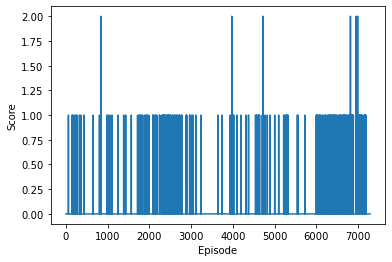

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


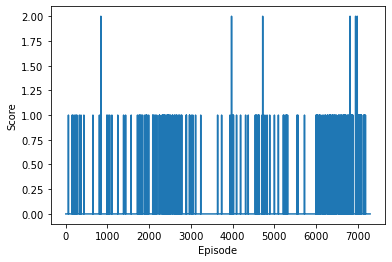

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


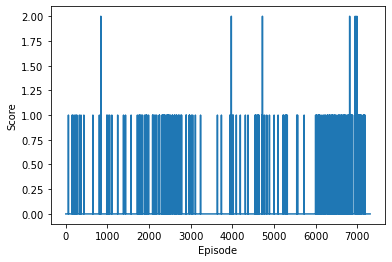

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


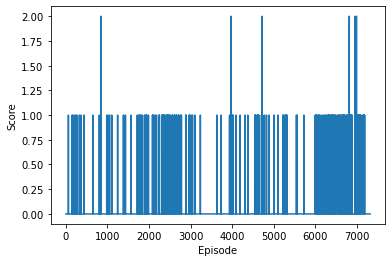

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


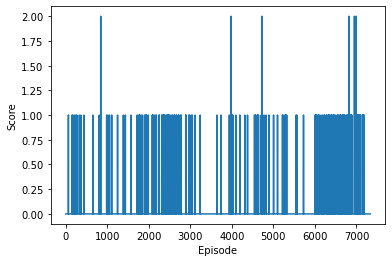

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


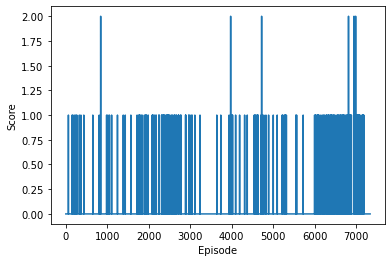

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


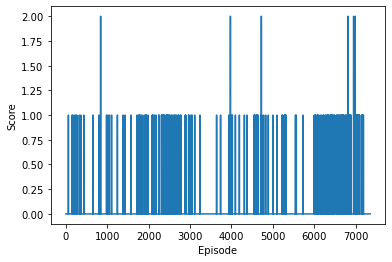

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


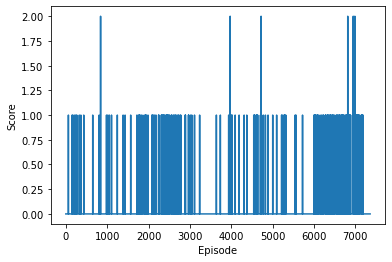

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


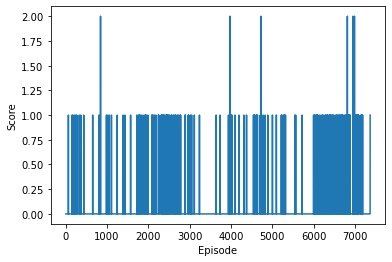

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


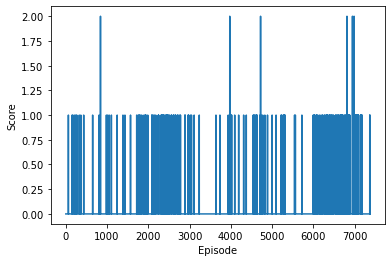

INFO:tensorflow:Assets written to: ./save/model1\assets
INFO:tensorflow:Assets written to: ./save/model2\assets
INFO:tensorflow:Assets written to: ./model1\assets
INFO:tensorflow:Assets written to: ./model2\assets
SCORE v. EPISODE


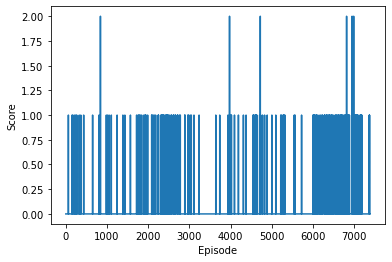

In [9]:
game = snake.game()
x = 0

while True:
    # print("Training agent on episode " + str(x))
    dqn = agent(game)

    game.start(dqn)

    if x % 10 == 0:
        q1.save(save_path + "/model1", overwrite=True, include_optimizer=True)
        q2.save(save_path + "/model2", overwrite=True, include_optimizer=True)
        q1.save(model_path + "1", overwrite=True, include_optimizer=True)
        q2.save(model_path + "2", overwrite=True, include_optimizer=True)
        with open(save_path + "/update_index.dat", "wb") as openfile:
            pickle.dump(update_index, openfile)
        with open(save_path + "/filled_memory.dat", "wb") as openfile:
            pickle.dump(filled_memory, openfile)
        with open(save_path + "/states_memory.dat", "wb") as openfile:
            pickle.dump(states_memory, openfile)
        with open(save_path + "/action_memory.dat", "wb") as openfile:
            pickle.dump(action_memory, openfile)
        with open(save_path + "/reward_memory.dat", "wb") as openfile:
            pickle.dump(reward_memory, openfile)
        with open(save_path + "/transitions_memory.dat", "wb") as openfile:
            pickle.dump(transitions_memory, openfile)
        # with open(save_path + "/average_loss.dat", "wb") as openfile:
        #     pickle.dump(average_loss, openfile)
        with open(save_path + "/scores.dat", "wb") as openfile:
            pickle.dump(scores, openfile)

        plot()
    x += 1

    # print("Finished episode " + str(x) + ", agent scored " + str(game.score) + " points.")
    scores.append(game.score)